In [1]:
# In this kernel I will do some analysis on the collected data sets
# Exploring the data sets will yield a better understanding of the data 
# And will help in making feature selection

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Paths to the csv files holding the collected data

# advanced team stats
path_team_stats_advanced19 = r"C:\Python\March Madness\NCAA_Team_Data_Advanced19.csv"
path_team_stats_advanced18 = r"C:\Python\March Madness\NCAA_Team_Data_Advanced18.csv"

# basic team stats
path_team_stats_basic19 = r"C:\Python\March Madness\NCAA_Team_Data_Basic19.csv"
path_team_stats_basic18 = r"C:\Python\March Madness\NCAA_Team_Data_Basic18.csv"

# regular season games
path_games19 = r"C:\Python\March Madness\NCAA_Reg_Season19.csv"
path_games18 = r"C:\Python\March Madness\NCAA_Reg_Season18.csv"


# Turn each csv file into a pandas dataframe
df_team_stats_advanced19 = pd.read_csv(path_team_stats_advanced19)
df_team_stats_advanced18 = pd.read_csv(path_team_stats_advanced18)

df_team_stats_basic19 = pd.read_csv(path_team_stats_basic19)
df_team_stats_basic18 = pd.read_csv(path_team_stats_basic18)

df_games19 = pd.read_csv(path_games19)
df_games18 = pd.read_csv(path_games18)

# Append the basic and advancd team stats dataframes (removed some redundant columns)
df_team_stats18 = pd.merge(df_team_stats_basic18, df_team_stats_advanced18[['SCHOOL','PACE','ORTg','FTr','3PAr','TS%','TRB%','AST%','STL%','BLK%','eFG%','TOV%','ORB%','FT/FGA']],
                                                                            on='SCHOOL', how='outer')
df_team_stats19 = pd.merge(df_team_stats_basic19, df_team_stats_advanced19[['SCHOOL','PACE','ORTg','FTr','3PAr','TS%','TRB%','AST%','STL%','BLK%','eFG%','TOV%','ORB%','FT/FGA']],
                                                                            on='SCHOOL', how='outer')

In [4]:
# Each year has 2 corresponding data frames: df_team_stats and df_games
# Lets check an overview of the data sets

df_games19.head(10)

,Date,Team,Rank,Away?,Opponent,Opp Rank,W/L,Points,Opp Points,Point Diff.,OT
0,3/28/2019,Florida State,10.0,NaN,Gonzaga,4.0,L,58,72,-14,NaN
1,3/28/2019,Gonzaga,4.0,NaN,Florida State,10.0,W,72,58,14,NaN
2,3/28/2019,Hampton,NaN,@,NJIT,NaN,W,82,70,12,NaN
3,3/28/2019,NJIT,NaN,NaN,Hampton,NaN,L,70,82,-12,NaN
4,3/28/2019,Loyola Marymount,NaN,@,South Florida,NaN,L,47,56,-9,NaN
5,3/28/2019,South Florida,NaN,NaN,Loyola Marymount,NaN,W,56,47,9,NaN
6,3/28/2019,Purdue,13.0,NaN,Tennessee,6.0,W,99,94,5,1.0
7,3/28/2019,Tennessee,6.0,NaN,Purdue,13.0,L,94,99,-5,1.0
8,3/28/2019,Louisiana-Monroe,NaN,NaN,Texas Southern,NaN,L,102,108,-6,3.0
9,3/28/2019,Texas Southern,NaN,@,Louisiana-Monroe,NaN,W,108,102,6,3.0


In [5]:
# The first thing I notice is that each game gets written as 2 rows from either teams perspective
# This is something I adjusted for in the match stats func

# Not every game has a home team. This is because some games are played in neutral stdaiums
# for things like tournaments or on special occasions

In [6]:
print(df_games18.info(),'\n')
print(df_games19.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11544 entries, 0 to 11543
Data columns (total 11 columns):
Date           11544 non-null object
Team           11544 non-null object
Rank           891 non-null float64
Away?          4877 non-null object
Opponent       11544 non-null object
Opp Rank       889 non-null float64
W/L            11544 non-null object
Points         11544 non-null int64
Opp Points     11544 non-null int64
Point Diff.    11544 non-null int64
OT             732 non-null float64
dtypes: float64(3), int64(3), object(5)
memory usage: 992.1+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11610 entries, 0 to 11609
Data columns (total 11 columns):
Date           11610 non-null object
Team           11610 non-null object
Rank           883 non-null float64
Away?          4919 non-null object
Opponent       11610 non-null object
Opp Rank       880 non-null float64
W/L            11610 non-null object
Points         11610 non-null int64
Opp Points     1161

In [7]:
# After accounting for the doubling of games, we have roughly 11,000 data points to train the model
# We can also see that ~5% of games go into overtime

In [8]:
df_team_stats19.head(10)

,SCHOOL,RANK,GAMES,WINS,LOSS,W/L%,SRS,SOS,CONF. W,CONF. L,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
0,Abilene Christian,1.0,34.0,27.0,7.0,0.794,-1.91,-7.34,14.0,4.0,...,0.345,0.565,50.3,58.5,12.9,8.0,0.535,15.5,28.8,0.239
1,Air Force,2.0,32.0,14.0,18.0,0.438,-4.28,0.24,8.0,10.0,...,0.400,0.541,50.1,54.1,7.0,5.8,0.517,17.4,23.7,0.192
2,Akron,3.0,33.0,17.0,16.0,0.515,4.86,1.09,8.0,10.0,...,0.477,0.515,48.2,50.1,8.2,8.9,0.485,15.0,25.3,0.195
3,Alabama A&M,4.0,32.0,5.0,27.0,0.156,-19.23,-8.38,4.0,14.0,...,0.318,0.479,47.0,52.2,10.7,4.6,0.458,19.4,27.6,0.157
4,Alabama-Birmingham,5.0,35.0,20.0,15.0,0.571,0.36,-1.52,10.0,8.0,...,0.346,0.537,52.7,44.3,9.3,7.5,0.511,14.8,30.4,0.212
5,Alabama State,6.0,31.0,12.0,19.0,0.387,-15.60,-7.84,9.0,9.0,...,0.382,0.499,48.9,44.0,9.3,9.3,0.465,17.8,30.9,0.253
6,Alabama,7.0,34.0,18.0,16.0,0.529,9.45,9.01,8.0,10.0,...,0.369,0.533,52.0,48.8,6.6,11.6,0.503,16.8,31.5,0.253
7,Albany (NY),8.0,32.0,12.0,20.0,0.375,-9.37,-6.70,7.0,9.0,...,0.451,0.533,49.7,55.2,9.0,7.1,0.494,18.4,27.1,0.240
8,Alcorn State,9.0,31.0,10.0,21.0,0.323,-22.08,-8.97,6.0,12.0,...,0.375,0.504,49.9,55.1,10.7,9.8,0.473,19.9,30.1,0.213
9,American,10.0,30.0,15.0,15.0,0.500,-4.19,-7.22,9.0,9.0,...,0.355,0.562,50.4,51.4,10.7,11.0,0.533,16.7,26.1,0.250


In [9]:
df_team_stats19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 0 to 352
Data columns (total 46 columns):
SCHOOL                353 non-null object
RANK                  353 non-null float64
GAMES                 353 non-null float64
WINS                  353 non-null float64
LOSS                  353 non-null float64
W/L%                  353 non-null float64
SRS                   353 non-null float64
SOS                   353 non-null float64
CONF. W               353 non-null float64
CONF. L               353 non-null float64
HOME W                353 non-null float64
HOME L                353 non-null float64
AWAY W                353 non-null float64
AWAY L                353 non-null float64
POINTS SCORED         353 non-null float64
POINTS ALLOWED        353 non-null float64
MINUTES PLAYED        353 non-null float64
FG                    353 non-null float64
FGA                   353 non-null float64
FG%                   353 non-null float64
3P                    353 non-null f

In [10]:
# There are 351 and 353 teams for each year and no null values which is great to see

In [11]:
# There are quite a few redundant or uneeded columns in this dataframe:

# Wins and losses are listed in a variety of ways

# Shooting metrics have a column for each of shots made, shots attempted and shooting percentage
# The only relevant piece their is the shooting percentage since not every team plays the same number of games

# Rebounds, assists, blocks etc. are season totals rather than per game averages.
# Again this is a problem since the number of games played is not uniform
# Since there are advanced metrics on these categories, I will use those instead

# There are a few others as well that are either redundant or obviously bad feature choices that I will discard below
df_team_stats19 = df_team_stats19.drop(['RANK','GAMES','WINS','LOSS','CONF. W','CONF. L',
                                               'HOME W','HOME L','AWAY W','AWAY L','POINTS SCORED',
                                               'POINTS ALLOWED','MINUTES PLAYED','FG','FGA','3P','3PA',
                                               'FT','FTA','OFFENSIVE REBOUNDS','TOTAL REBOUNDS','ASISTS',
                                               'STEALS','BLOCKS','TURN OVERS','PF'], axis=1)
df_team_stats18 = df_team_stats18.drop(['RANK','GAMES','WINS','LOSS','CONF. W','CONF. L',
                                               'HOME W','HOME L','AWAY W','AWAY L','POINTS SCORED',
                                               'POINTS ALLOWED','MINUTES PLAYED','FG','FGA','3P','3PA',
                                               'FT','FTA','OFFENSIVE REBOUNDS','TOTAL REBOUNDS','ASISTS',
                                               'STEALS','BLOCKS','TURN OVERS','PF'], axis=1)

In [12]:
print(df_team_stats18.info(),"\n")
print(df_team_stats19.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 350
Data columns (total 20 columns):
SCHOOL    351 non-null object
W/L%      351 non-null float64
SRS       351 non-null float64
SOS       351 non-null float64
FG%       351 non-null float64
3P%       351 non-null float64
FT%       351 non-null float64
PACE      351 non-null float64
ORTg      351 non-null float64
FTr       351 non-null float64
3PAr      351 non-null float64
TS%       351 non-null float64
TRB%      351 non-null float64
AST%      351 non-null float64
STL%      351 non-null float64
BLK%      351 non-null float64
eFG%      351 non-null float64
TOV%      351 non-null float64
ORB%      351 non-null float64
FT/FGA    351 non-null float64
dtypes: float64(19), object(1)
memory usage: 57.6+ KB
None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353 entries, 0 to 352
Data columns (total 20 columns):
SCHOOL    353 non-null object
W/L%      353 non-null float64
SRS       353 non-null float64
SOS       353 non-

In [13]:
# Now I want to check if we have all the team data for each match in the data set

# The game_error_counter() function iterates through each game in df_games 
# and checks df_team_stats to see if we have the corresponding team stats for both schools in the game
# The function then counts and prints the total number of invalid games

In [14]:
from functions import game_error_counter

game_error_counter(df_games19, df_team_stats19)
game_error_counter(df_games18, df_team_stats18)

Number of errors:  63
Number of errors:  60


In [15]:
# The small number of errors is because some larger schools will occasionally play a 
# very small one, leading to the match data being available but the data for both teams is not

# This error checker also shows that we have no large inconsistencies between the 2 data sets
# and we can reliably match the stats of each team to a game

In [16]:
# Now I need to condense the multiple dataframes into one so we can train the model

# Since the model wont be able to compare two feature sets per game (one from each team)
# I took the difference of Team A's and Team B's stat lines and added the result column
# that denotes if Team A won or loss


# The match_stats_reg_season function calculates the match stats of each game
# and saves it to a list that will be used to create the final dataframe


In [17]:
from functions import match_stats_reg_season

reg_season = []
match_stats_reg_season(reg_season,df_games19,df_team_stats19);
match_stats_reg_season(reg_season,df_games18,df_team_stats18);

In [18]:
cols = ['W/L%','SRS','SOS','FG%','3P%','FT%','PACE','ORTg','FTr','3PAr','TS%',
        'TRB%','AST%','STL%','BLK%','eFG%','TOV%','ORB%','FT/FGA','RESULT']

df_match_stats = pd.DataFrame(columns=cols,data=reg_season)

# Encode the categorical variable RESULT: 0 is a win, 1 is a loss
df_match_stats['RESULT'] = pd.get_dummies(df_match_stats['RESULT'])

# Turn the objects to float
df_match_stats = df_match_stats.astype(float)

# Save the df to csv file so it can be used in a seperate file
export_csv  = df_match_stats.to_csv(r"C:\Python\March Madness\Match_Stats.csv",index=None,header=True,)


In [19]:
df_match_stats.head()

,W/L%,SRS,SOS,FG%,3P%,FT%,PACE,ORTg,FTr,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA,RESULT
0,-0.108,-9.80,5.25,-0.084,-0.031,-0.017,-2.2,-15.9,0.005,0.024,-0.075,-1.5,-6.7,-0.3,-1.0,-0.085,3.1,1.9,-0.002,1.0
1,-0.115,0.28,-0.32,-0.012,0.000,0.066,4.1,7.3,-0.030,0.004,-0.002,2.1,6.1,-0.9,1.8,-0.011,-3.0,5.8,0.002,0.0
2,0.015,-3.03,-0.79,0.024,-0.012,0.100,-4.3,0.9,-0.122,-0.103,0.012,-2.5,-0.9,0.0,0.8,0.005,-2.0,-6.0,-0.043,1.0
3,-0.116,-0.15,1.83,-0.045,0.007,-0.035,-3.3,-1.8,-0.034,0.135,-0.024,1.4,-6.1,0.6,-2.6,-0.018,-0.2,2.9,-0.036,0.0
4,-0.089,6.36,5.03,-0.001,0.072,0.114,-7.1,7.6,-0.052,0.081,0.038,-1.3,-0.6,-2.0,-1.2,0.028,-2.8,-4.4,0.007,1.0


In [20]:
df_match_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11006 entries, 0 to 11005
Data columns (total 20 columns):
W/L%      11006 non-null float64
SRS       11006 non-null float64
SOS       11006 non-null float64
FG%       11006 non-null float64
3P%       11006 non-null float64
FT%       11006 non-null float64
PACE      11006 non-null float64
ORTg      11006 non-null float64
FTr       11006 non-null float64
3PAr      11006 non-null float64
TS%       11006 non-null float64
TRB%      11006 non-null float64
AST%      11006 non-null float64
STL%      11006 non-null float64
BLK%      11006 non-null float64
eFG%      11006 non-null float64
TOV%      11006 non-null float64
ORB%      11006 non-null float64
FT/FGA    11006 non-null float64
RESULT    11006 non-null float64
dtypes: float64(20)
memory usage: 1.7 MB


In [21]:
# The original 45 feature choices has been cut to a more manageable 19 and
# and the original 6 df's has been merged to just one holding each games match stats

# Now that our data is all cleaned up, we can dive a bit deeper in order to further cut 
# down on the feature choices and possibly find some interesting bits of information

In [22]:
# First lets look at some descriptive statistics of our data to make sure nothing looks out of the ordinary
df_match_stats.describe()

,W/L%,SRS,SOS,FG%,3P%,FT%,PACE,ORTg,FTr,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA,RESULT
count,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000,11006.000000
mean,0.000410,-0.082863,-0.052516,-0.000450,0.000054,-0.000069,-0.056433,-0.054089,0.000141,0.000629,-0.000288,0.040969,0.041941,-0.007932,0.059041,-0.000329,0.040923,0.094385,0.000047,0.503907
std,0.232222,10.860261,4.877269,0.033179,0.034627,0.049997,3.746989,7.736760,0.062050,0.072212,0.036882,3.555778,6.966408,2.080830,3.403740,0.039298,2.276520,5.244646,0.046377,0.500007
min,-0.763000,-45.260000,-21.330000,-0.137000,-0.130000,-0.218000,-17.400000,-30.700000,-0.217000,-0.301000,-0.147000,-13.100000,-27.500000,-7.400000,-12.500000,-0.164000,-8.600000,-22.100000,-0.149000,0.000000
25%,-0.156000,-6.407500,-1.780000,-0.022000,-0.023000,-0.034000,-2.500000,-5.100000,-0.041000,-0.047000,-0.024000,-2.300000,-4.700000,-1.400000,-2.200000,-0.026000,-1.400000,-3.500000,-0.031000,0.000000
50%,0.000000,-0.090000,-0.010000,-0.001000,0.000000,0.000000,-0.100000,0.000000,-0.001000,0.001000,-0.001000,0.000000,0.100000,0.000000,0.100000,0.000000,0.100000,0.100000,0.000000,1.000000
75%,0.157750,6.380000,1.720000,0.022000,0.023000,0.033750,2.300000,5.000000,0.042000,0.049000,0.024000,2.400000,4.700000,1.300000,2.300000,0.026000,1.500000,3.700000,0.032000,1.000000
max,0.763000,44.940000,20.350000,0.124000,0.134000,0.172000,23.000000,28.400000,0.229000,0.305000,0.141000,13.300000,28.900000,7.400000,13.300000,0.153000,8.600000,19.500000,0.153000,1.000000


In [23]:
# It is expected that the mean for each column is approximately 0 since each stat
# was calculated by taking the difference of team A and team B

# Both accounts are true and nothing seems abnormal so lets move on to feature selection

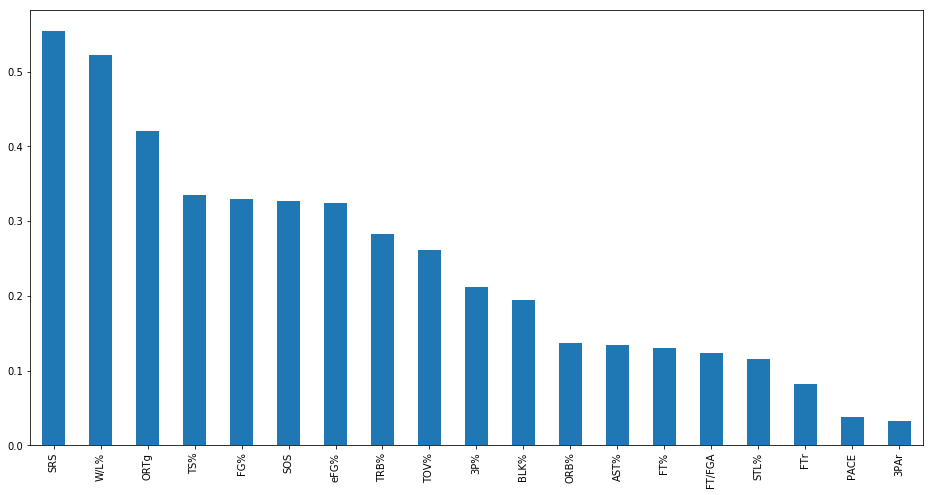

In [24]:
corr = np.abs(df_match_stats.corr(method='pearson'))
corr['RESULT'].sort_values(ascending=False).drop('RESULT').plot(kind='bar',figsize=(16,8))

# This graph shows the correlation coefficient of each feature and the result column

In [25]:
# It is pretty clear that some features have a stronger correlation 

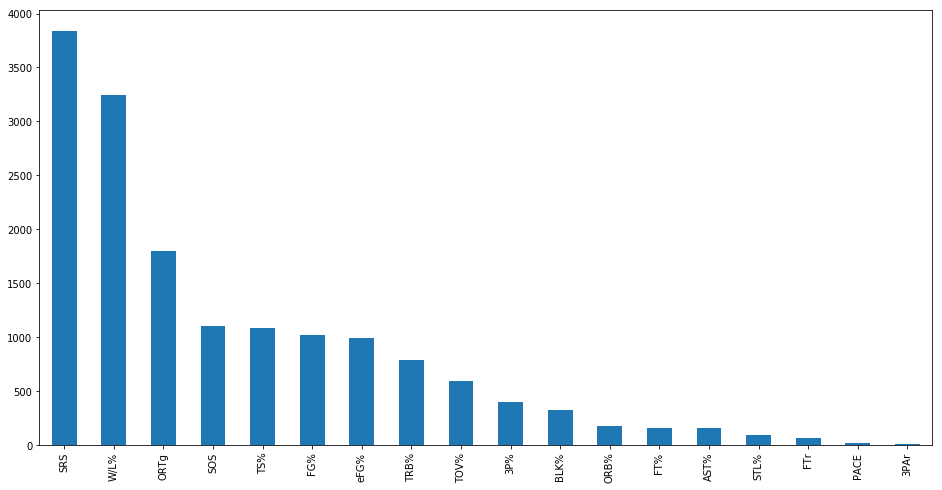

In [26]:
# Univariate Feature Selection works by analyzing each individual feature to find how strong of 
# a relationship it has with the dependant variable

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile

all_x = df_match_stats[cols[0:-2]]
all_y = df_match_stats['RESULT'] 

x_train, x_test, y_train, y_test = train_test_split(all_x,all_y,test_size = 0.2, random_state=0)

select = SelectPercentile(percentile=5)
select.fit(x_train,y_train)
x_train_selected = select.transform(x_train)
scores = select.scores_

feature_importances = pd.DataFrame(scores,index = x_train.columns,columns=['importance']).sort_values('importance',
                                   ascending=False)

feature_importances['importance'].plot(kind='bar',figsize=(16,8))

In [27]:
# The Univariate analysis shows only a slight differences from the pearson correlations.
# slightly shuffling around the SOS, TS% AND FG% features

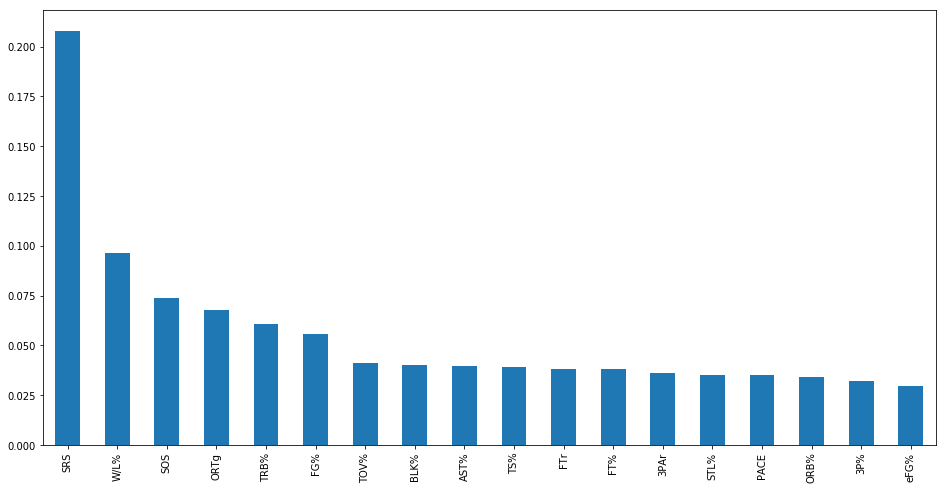

In [28]:
# Random Forest has a feature importance tool I will use to make a final comparison

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(x_train, y_train)

feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_train.columns,
                                   columns=['importance']).sort_values('importance',
                                   ascending=False)

feature_importances['importance'].plot(kind='bar',figsize=(16,8))

In [29]:
# This chart agrees that SRS, W/L%, ORTg and SOS are good features, but not so much the rest
# Since these four consistently ranked high in all three analysis, they will make up the final feature set

In [30]:
# Below is a brief description of these four features

# SRS = simple rating system
# it takes into account point differential and strength of schedule

# W/L% = win loss percentage
# simply the number of wins/games played during the season

# ORTg = offensive rating
# this metric estimates how many points a team scores per 100 possesions 

# SOS = strength of schedule
# measures how difficult the teams you played were

# Lastly, we can check the correltaion between the features themselves to make sure 
# that none of them are too high
corr

,W/L%,SRS,SOS,FG%,3P%,FT%,PACE,ORTg,FTr,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA,RESULT
W/L%,1.000000,0.816664,0.168331,0.634253,0.424334,0.231475,0.021603,0.785053,0.148875,0.063269,0.643177,0.526803,0.230617,0.239320,0.286924,0.626675,0.463047,0.238295,0.223050,0.522732
SRS,0.816664,1.000000,0.636773,0.582935,0.382736,0.235571,0.097712,0.740114,0.109580,0.055509,0.589366,0.510481,0.238096,0.167530,0.337231,0.574124,0.454094,0.240524,0.186193,0.554014
SOS,0.168331,0.636773,1.000000,0.088204,0.040294,0.073664,0.105191,0.173282,0.019267,0.015452,0.095939,0.107780,0.081261,0.014012,0.231904,0.086654,0.174329,0.077896,0.042146,0.327301
FG%,0.634253,0.582935,0.088204,1.000000,0.586077,0.204582,0.042440,0.785867,0.085458,0.059393,0.903206,0.360268,0.265380,0.071404,0.113963,0.924426,0.191698,0.013977,0.154335,0.328928
3P%,0.424334,0.382736,0.040294,0.586077,1.000000,0.334638,0.044214,0.629542,0.080375,0.213713,0.725116,0.137402,0.238243,0.100773,0.032941,0.730241,0.231563,0.148189,0.043076,0.212210
FT%,0.231475,0.235571,0.073664,0.204582,0.334638,1.000000,0.021133,0.403252,0.031219,0.215701,0.463273,0.082133,0.120681,0.167788,0.065371,0.298333,0.202048,0.145683,0.328500,0.129825
PACE,0.021603,0.097712,0.105191,0.042440,0.044214,0.021133,1.000000,0.085601,0.221713,0.031179,0.069043,0.101995,0.017907,0.068293,0.063504,0.037286,0.053238,0.018206,0.216677,0.037476
ORTg,0.785053,0.740114,0.173282,0.785867,0.629542,0.403252,0.085601,1.000000,0.060935,0.175029,0.847060,0.463903,0.252523,0.068237,0.120173,0.825872,0.594715,0.215732,0.201218,0.420987
FTr,0.148875,0.109580,0.019267,0.085458,0.080375,0.031219,0.221713,0.060935,1.000000,0.304072,0.097507,0.194253,0.049740,0.006162,0.097822,0.038145,0.177141,0.201361,0.932341,0.082602
3PAr,0.063269,0.055509,0.015452,0.059393,0.213713,0.215701,0.031179,0.175029,0.304072,1.000000,0.276670,0.247020,0.273867,0.116712,0.197862,0.302077,0.119238,0.368487,0.212514,0.032661
